# ***Tarea 2. Regresión Lineal Múltiple***
### Luis Eduardo Jiménez del Muro - 04/02/2025
---

## Paqueterías

In [1]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Instrucciones

Más informacióm del dataset 

El objetivo es predecir cuantas vicicletas se van a rentar

https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset


Quita las variables de casual, registered, instant, fecha, mes, año de tu entrenamiento

Hay varias categoricas, cuales son? coviertelas e one hot encoding 

Crea variables dummy 

In [2]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Borrar las variables que no se utilizarán

In [3]:
df_model = df.drop(columns=['casual', 'registered', 'instant', 'yr', 'mnth', 'dteday'])
df_model.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## Obtener variables dummy

In [4]:
df_model_encoded = pd.get_dummies(df_model, columns=['season', 'weekday', 'weathersit'])
df_model_encoded.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0.344167,0.363625,0.805833,0.160446,985,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,0,0.363478,0.353739,0.696087,0.248539,801,True,False,False,...,True,False,False,False,False,False,False,False,True,False
2,0,1,0.196364,0.189405,0.437273,0.248309,1349,True,False,False,...,False,True,False,False,False,False,False,True,False,False
3,0,1,0.200000,0.212122,0.590435,0.160296,1562,True,False,False,...,False,False,True,False,False,False,False,True,False,False
4,0,1,0.226957,0.229270,0.436957,0.186900,1600,True,False,False,...,False,False,False,True,False,False,False,True,False,False


## Visualización de datos

### Variables numéricas contra la variable objetivo.

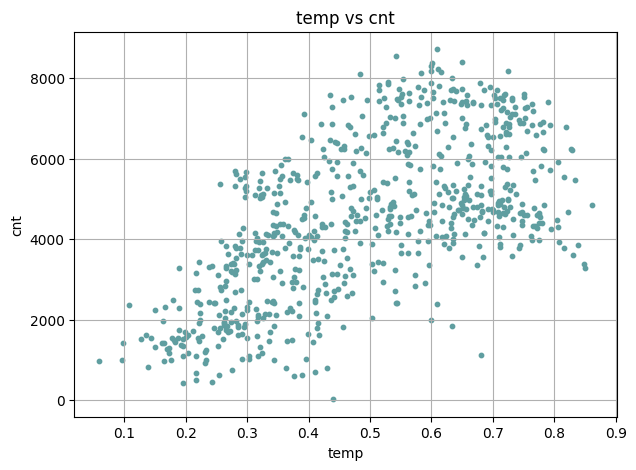

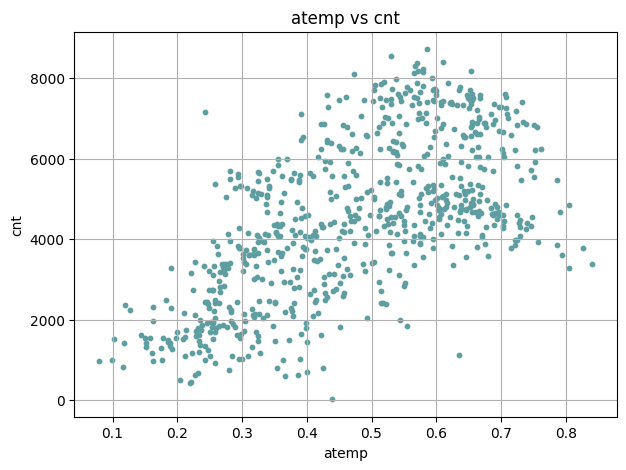

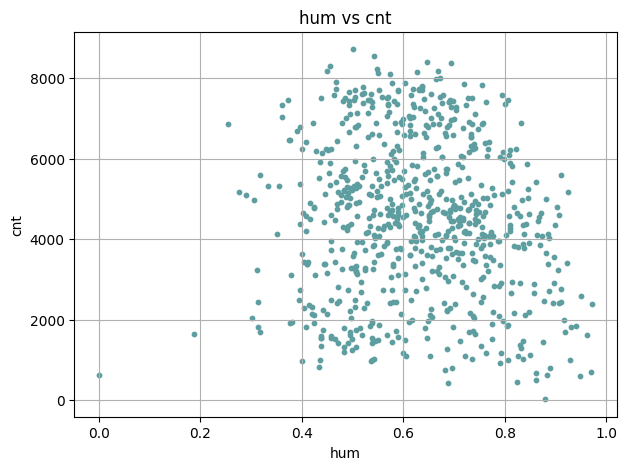

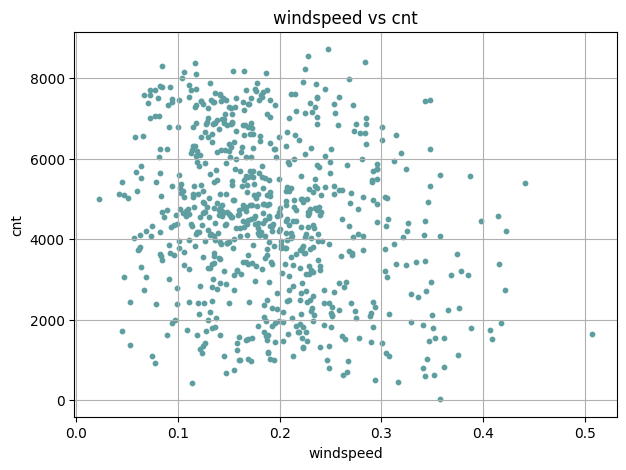

In [5]:
# Función para hacer el la gráfica de dispersión
def scatter_plot(x, y):
    plt.figure(figsize=(7, 5))
    plt.scatter(x, y, color='cadetblue', s=10)
    plt.title(f'{x.name} vs {y.name}')
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.grid()
    plt.show()

numericas = ['temp', 'atemp', 'hum', 'windspeed']
for i in range(len(numericas)):
    scatter_plot(df_model_encoded[numericas[i]], df_model_encoded['cnt'])

+ Podemos observar que las variables `temp` y `atemp` tienen relación positiva con `cnt`.
+ Las demás variables parecen ser solo nubes de puntos sin mucha relación con la variable objetivo.

### Análisis bivariado

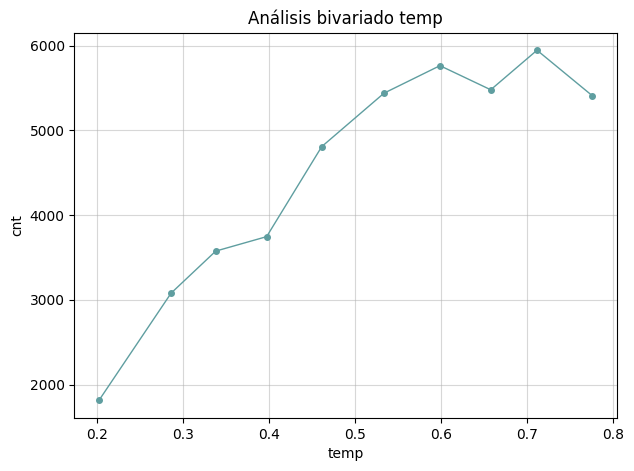

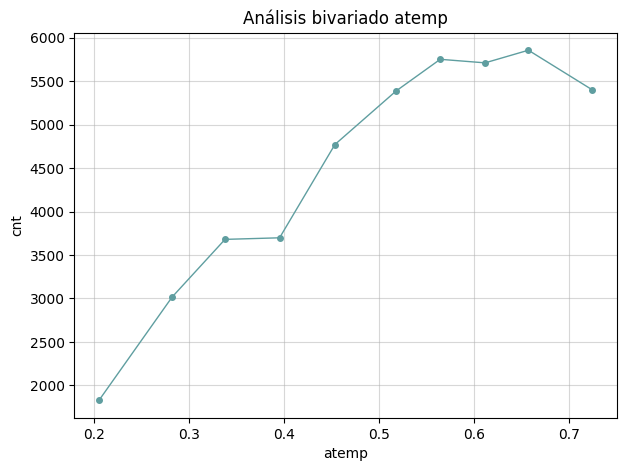

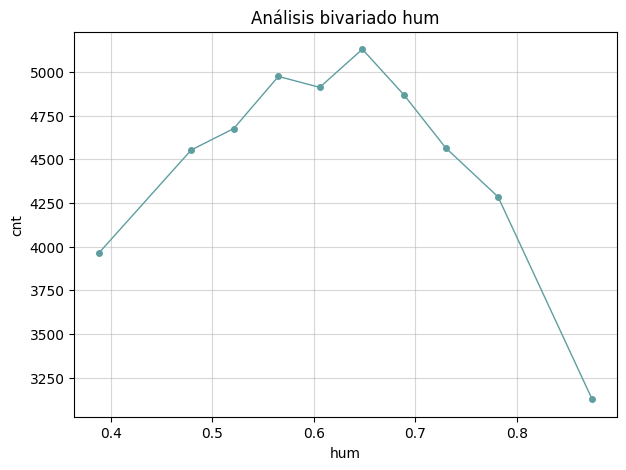

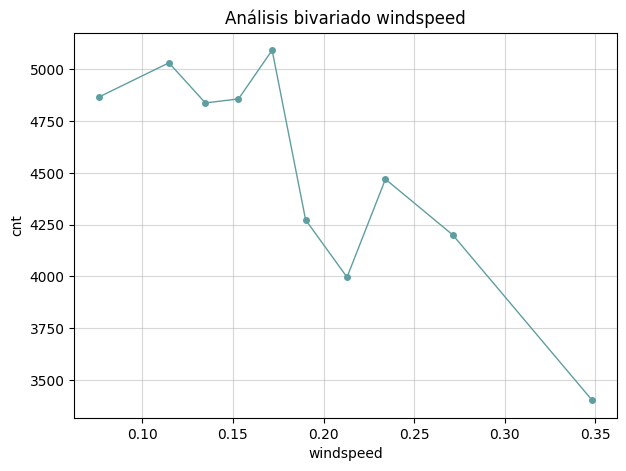

In [6]:
# Función para la gráfica de análisis Bivariado
def graficar_bivariado(grouped_data_x, grouped_data_y):
    plt.figure(figsize=(7, 5))
    plt.plot(grouped_data_x, grouped_data_y, marker='o', color='cadetblue', lw=1, markersize=4)
    plt.title(f'Análisis bivariado {grouped_data_x.name}')
    plt.ylabel('cnt')
    plt.xlabel(grouped_data_x.name)
    plt.grid(alpha=0.5)
    
for i in range(len(numericas)):
    df_model_encoded[f'{numericas[i]}_bins'] = pd.qcut(df_model_encoded[numericas[i]], q=10, labels=False) + 1
    grouped_data = df_model_encoded.groupby(f'{numericas[i]}_bins').mean()
    graficar_bivariado(grouped_data[numericas[i]], grouped_data['cnt'])

+ Ninguna de las variables parece tener una relación lineal fuerte con el número de bicicletas.
+ La variable `hum` parece tener una relación cuadrática, por lo que, se hará una prueba elevando al cuadrado y tratar de ajustar una parábola.
+ Las variables `temp` y `atemp` parecen ser las colas izquierdas y `windspeed` la cola derechade una parábola. Por lo tanto, aunque no sea tan clara una relación cuadrática, se hará una prueba elevando al cuadrado las variables

## Modelos de prueba

### Regresión lineal múltiple (sin elevar `hum` al cuadrado)

In [7]:
target = 'cnt'
model = LinearRegression()

def train_model(model_type):
    X = df_model_encoded.drop(columns=[target])
    y = df_model_encoded[target]
    model = model_type.fit(X, y)
    r2 = r2_score(y_pred=model.predict(X), y_true=y)
    print(f'R2 del modelo {str(model_type)[:-2]} = {r2:.4f}')

train_model(model)

R2 del modelo LinearRegression = 0.5649


### Regresión lineal múltiple (elevando `hum` al cuadrado)

In [8]:
df_model_encoded['hum'] = df_model_encoded['hum']**2

train_model(model)

R2 del modelo LinearRegression = 0.5694


El R2 del modelo de regresión lineal subió hasta casi 0.57, por lo tanto, observamos que si ayudó al modelo elevar al cuadrado la variable `hum`.

### Regresión lineal múltiple (elevando todas las variables numéricas al cuadrado)

In [9]:
df_model_encoded['temp'] = df_model_encoded['temp']**2
df_model_encoded['atemp'] = df_model_encoded['atemp']**2
df_model_encoded['windspeed'] = df_model_encoded['windspeed']**2

train_model(model)

R2 del modelo LinearRegression = 0.5874


Elevando las variables numéricas al cuadrado se observó una mejora, incrementando el R2 hasta casi 0.59, esto confirma que la relación que la relación cuadrática es mayor a la relación lineal.

## Modelo final

### Resultados

El modelo final consiste en crear variables dummy, y elevar al cuadrado las variables numéricas.

In [10]:
target = 'cnt'
X = df_model_encoded.drop(columns=[target])
y = df_model_encoded[target]

model = LinearRegression().fit(X, y)
r2 = r2_score(y_pred=model.predict(X), y_true=y)

resultados = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_,
    })

print(f'El R2 del modelo de Regresión Lineal es de {r2:.4f}')
print(f'El MSE del modelo es de {mean_squared_error(y_pred=model.predict(X), y_true=y):.4f}')
print('\n\nLos coeficientes son del modelo son:')
display(resultados)

El R2 del modelo de Regresión Lineal es de 0.5874
El MSE del modelo es de 1546394.2733


Los coeficientes son del modelo son:


,Variable,Coeficiente
0,holiday,-381.492743
1,workingday,204.148382
2,temp,-4914.862759
3,atemp,-6169.593821
4,hum,-3858.836873
5,windspeed,-4517.271762
6,season_1,-737.875598
7,season_2,111.839547
8,season_3,-17.282002
9,season_4,643.318053


### Gráfica de ajuste del modelo 

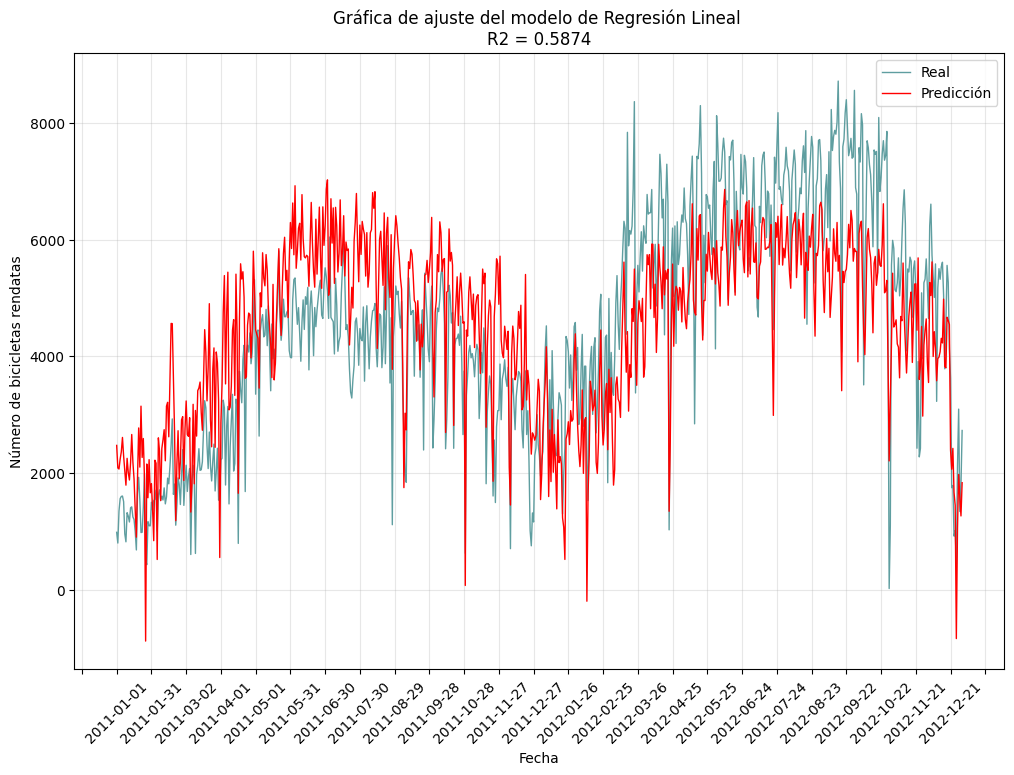

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(df['dteday'], df['cnt'], label='Real', color='cadetblue', lw=1)
plt.plot(df['dteday'], model.predict(X), label='Predicción', color='red', lw=1, alpha=1)
plt.xlabel('Fecha')
plt.ylabel('Número de bicicletas rendatas')
plt.xticks(rotation=45)
plt.title(f'Gráfica de ajuste del modelo de Regresión Lineal \nR2 = {r2:.4f}')
plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))
plt.grid(alpha=0.3)
plt.show()